# GRU model
In this file, we will build a GRU-based predtion model with the stock time series dataset.

## 1. Get the data

In [1]:
# Load dataset from datasets folder
import os
import pandas as pd
import torch
from pathlib import Path
folder_path = Path("../datasets/stock-time-series-20050101-to-20171231/")
data_path = folder_path / "all_stocks_2006-01-01_to_2018-01-01.csv"


df = pd.read_csv(data_path)

print(df.head())

         Date   Open   High    Low  Close   Volume Name
0  2006-01-03  77.76  79.35  77.24  79.11  3117200  MMM
1  2006-01-04  79.49  79.49  78.25  78.71  2558000  MMM
2  2006-01-05  78.41  78.65  77.56  77.99  2529500  MMM
3  2006-01-06  78.64  78.90  77.64  78.63  2479500  MMM
4  2006-01-09  78.50  79.83  78.46  79.02  1845600  MMM


In [2]:
len(df)

93612

Divide the dataset into train set and test set

In [3]:
train_ratio = 0.8
train_idx = int(len(df)*train_ratio)

df_train = df[:train_idx]
df_test = df[train_idx:]

print(f"Length of train set: {len(df_train)}")
print(f"Length of test set: {len(df_test)}")

Length of train set: 74889
Length of test set: 18723


## 2. Explore the data

In [4]:
print(df_train.describe)

<bound method NDFrame.describe of              Date    Open    High     Low   Close   Volume Name
0      2006-01-03   77.76   79.35   77.24   79.11  3117200  MMM
1      2006-01-04   79.49   79.49   78.25   78.71  2558000  MMM
2      2006-01-05   78.41   78.65   77.56   77.99  2529500  MMM
3      2006-01-06   78.64   78.90   77.64   78.63  2479500  MMM
4      2006-01-09   78.50   79.83   78.46   79.02  1845600  MMM
...           ...     ...     ...     ...     ...      ...  ...
74884  2015-07-30   99.38  101.29   99.00  100.73  6739131  UTX
74885  2015-07-31  100.92  101.49  100.25  100.31  7217241  UTX
74886  2015-08-03  100.31  100.31   98.18   99.42  7123692  UTX
74887  2015-08-04  100.03  100.12   98.90   99.03  5557563  UTX
74888  2015-08-05   99.97  100.13   98.73   98.87  3895578  UTX

[74889 rows x 7 columns]>


Check missing value

As we see, there are some missing value in Open, High and Low features. So we need to impute these value or simply drop the row ()
- The dropping method seems to be the easiest one since the dataset only contain small percentage of missing data.
- However, the test set also contain missing data so we need to impute them carefully.
- As the nature of time series data, the current value may depend on the previous values. 

-> So I will replace the missing values with the previous existing values.

In [5]:
df_train.fillna(method="ffill", inplace=True)
df_test.fillna(method="ffill", inplace=True)


C:\Users\letha\AppData\Local\Temp\ipykernel_15436\3355419247.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train.fillna(method="ffill", inplace=True)
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\3355419247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.fillna(method="ffill", inplace=True)
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\3355419247.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test.fillna(method="ffill", inplace=True)
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\3355419247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [6]:
df_train.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [7]:
df_test.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

We will extract the date data into day, month and year

Also, we will remove the Name feature, as all of them is the same

In [8]:
df_train["Date"] = pd.to_datetime(df_train["Date"])  # Convert to datetime

# Extract time-based features
df_train["Year"] = df_train["Date"].dt.year
df_train["Month"] = df_train["Date"].dt.month
df_train["Day"] = df_train["Date"].dt.day

C:\Users\letha\AppData\Local\Temp\ipykernel_15436\2432237394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Date"] = pd.to_datetime(df_train["Date"])  # Convert to datetime
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\2432237394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Year"] = df_train["Date"].dt.year
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\2432237394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [9]:
df_test["Date"] = pd.to_datetime(df_test["Date"])  # Convert to datetime

# Extract time-based features
df_test["Year"] = df_test["Date"].dt.year
df_test["Month"] = df_test["Date"].dt.month
df_test["Day"] = df_test["Date"].dt.day

C:\Users\letha\AppData\Local\Temp\ipykernel_15436\84110142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Date"] = pd.to_datetime(df_test["Date"])  # Convert to datetime
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\84110142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Year"] = df_test["Date"].dt.year
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\84110142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [10]:
df_train.drop(["Date", "Name"], axis="columns", inplace=True)
df_test.drop(["Date", "Name"], axis="columns", inplace=True)

C:\Users\letha\AppData\Local\Temp\ipykernel_15436\2538563255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["Date", "Name"], axis="columns", inplace=True)
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\2538563255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["Date", "Name"], axis="columns", inplace=True)


In [11]:
df_train.head()

,Open,High,Low,Close,Volume,Year,Month,Day
0,77.76,79.35,77.24,79.11,3117200,2006,1,3
1,79.49,79.49,78.25,78.71,2558000,2006,1,4
2,78.41,78.65,77.56,77.99,2529500,2006,1,5
3,78.64,78.90,77.64,78.63,2479500,2006,1,6
4,78.50,79.83,78.46,79.02,1845600,2006,1,9


### Data visualization

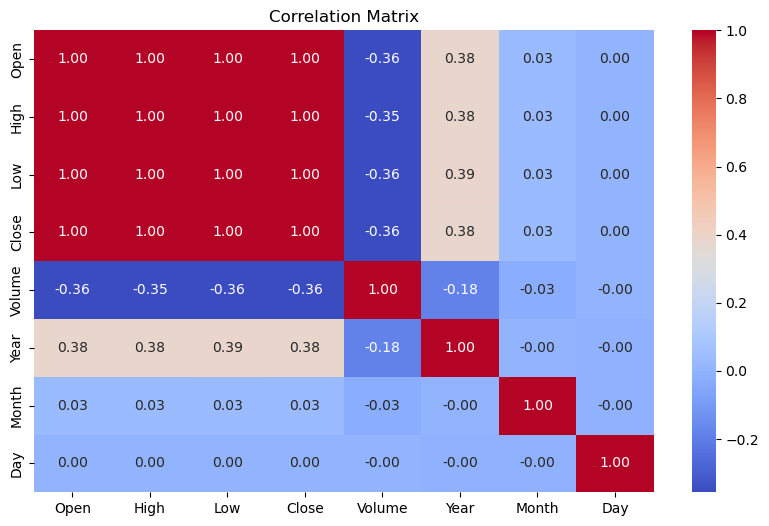

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

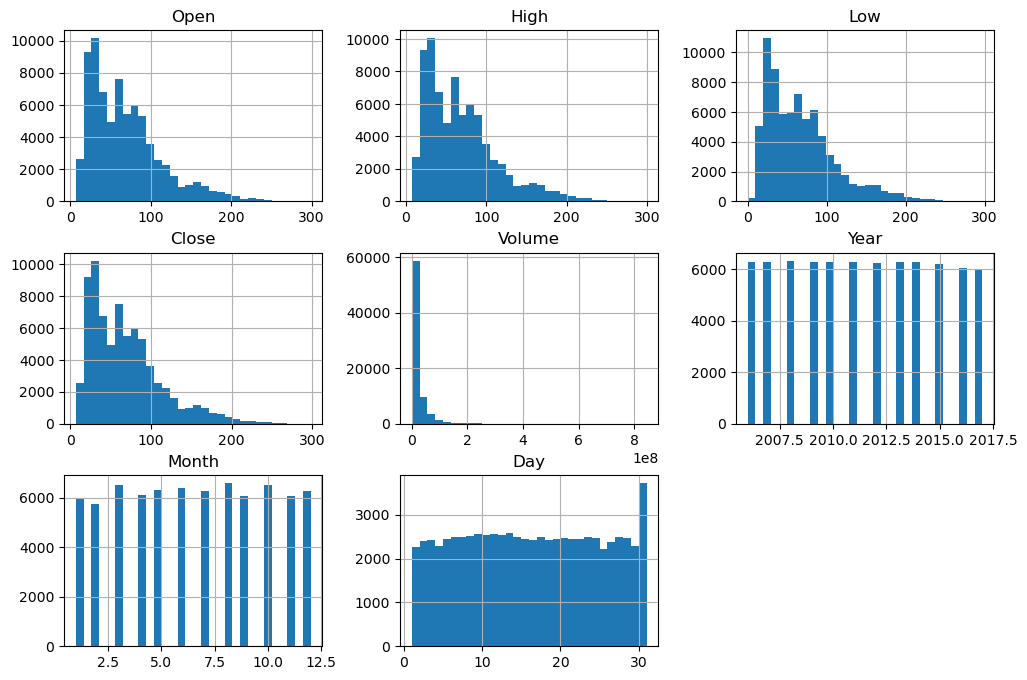

In [13]:
df_train.hist(figsize=(12, 8), bins=30)
plt.show()

## 3. Normalization

We will only normalizer the numeric features: Open, high, low, close, volumn

In [14]:
df_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day'], dtype='object')

In [15]:
normalized_features = ["Open", "High", "Low", "Close", "Volume"]

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train[normalized_features] = scaler.fit_transform(df_train[normalized_features])
df_test[normalized_features] = scaler.fit(df_test[normalized_features])

C:\Users\letha\AppData\Local\Temp\ipykernel_15436\389775546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[normalized_features] = scaler.fit_transform(df_train[normalized_features])
C:\Users\letha\AppData\Local\Temp\ipykernel_15436\389775546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[normalized_features] = scaler.fit(df_test[normalized_features])


### Create sequence
We will use the previous days to predict the next day Open price

In [17]:
from general_functions import *
seq_len = 10
train_dataset = create_sequences(df_train, df_train["Open"], seq_len)
test_dataset = create_sequences(df_test, df_test["Open"], seq_len)

### Create dataloader

In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dl = DataLoader(dataset=train_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True)

test_dl = DataLoader(dataset=test_dataset,
                     batch_size=BATCH_SIZE,
                     shuffle=False)

In [21]:
len(train_dl)

2340

## 4. Create GRU model